In [1]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=4e84363abda5c95d562a867cb0a13cfbbac98d7362e04279b02f0b4786174f83
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [2]:
import networkx as nx

# Load the graph from the file
all_network = nx.read_graphml('/content/all_network.graphml')
print("Graph has been loaded from all_network.graphml")


Graph has been loaded from all_network.graphml


GLOBAL ANALYSIS

In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=78858dd4beab91c1e11a722397660cd9feec0b204cfa0f31ac15bd6a4c5ef461
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [ ]:
import networkx as nx

# Load the graph from the file
all_network = nx.read_graphml('/content/all_network.graphml')
print("Graph has been loaded from all_network.graphml")


Graph has been loaded from all_network.graphml


In [3]:
# Sensitivity Analysis Script – Random Variable and BSP Interaction
# ---------------------------------------------------------------
# This script evaluates the robustness of an FCM model by:
# 1. Varying BSP input values using Latin Hypercube Sampling (LHS)
# 2. Repeating simulations under randomized random-node values



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re
from pyDOE import lhs
from scipy.stats import levene
import networkx as nx

def clean_node_name(name):
    name = str(name).strip().lower()
    name = unicodedata.normalize("NFKD", name)
    name = re.sub(r'[\u200b-\u200f\u202a-\u202e\u00a0]', '', name)
    return name

def normalize_weight(w, original_min=0, original_max=5, target_min=0, target_max=1):
    if w is None:
        return 0
    w = float(w)
    return ((w - original_min) / (original_max - original_min)) * (target_max - target_min) + target_min

def graph_to_fcm(g, weight_property=None, normalize=True):
    num_vertices = len(g.nodes())
    fcm_matrix = np.zeros((num_vertices, num_vertices))
    node_index = {node: idx for idx, node in enumerate(g.nodes())}
    for source, target, data in g.edges(data=True):
        source_idx = node_index[source]
        target_idx = node_index[target]
        if weight_property and weight_property in data:
            weight = data[weight_property]
            if normalize:
                weight = normalize_weight(weight)
            fcm_matrix[source_idx, target_idx] = weight
        else:
            fcm_matrix[source_idx, target_idx] = 1.0
    return fcm_matrix

def triangular_membership(x, a, b, c):
    if x < a or x > c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a) if (b - a) != 0 else 0.0
    else:
        return (c - x) / (c - b) if (c - b) != 0 else 0.0

def fuzzify_bsp_input(value):
    x = float(value)
    return [
        max(0, 1 - 4 * x),
        max(0, 1 - abs(4 * x - 1)),
        max(0, 1 - abs(4 * x - 2)),
        max(0, 1 - abs(4 * x - 3)),
        max(0, 4 * x - 3) if x >= 0.75 else 0
    ]

def defuzzify(fuzzy_vector):
    weights = [-1.0, -0.5, 0.0, 0.5, 1.0]
    return sum(f * w for f, w in zip(fuzzy_vector, weights)) / sum(fuzzy_vector)

def nonlinear_transition(weighted_sum, total_weight, alpha=1.5):
    if total_weight == 0:
        return 0.0
    return np.tanh(alpha * (weighted_sum / total_weight))

def initialize_fixed_fcm_state(graph, bsp_inputs, intermediate_values,
                               behavior_pattern=r"_behavior_\d+$",
                               random_keyword="random"):
    init_state = {}
    random_nodes = []
    root_nodes = []
    output_nodes = []

    for i, (node, data) in enumerate(graph.nodes(data=True)):
        name = clean_node_name(data.get('name', str(node)))
        label = clean_node_name(data.get('label', str(node)))
        is_random = random_keyword in name
        is_bsp = name in bsp_inputs
        is_behavior = re.search(behavior_pattern, label)
        is_root = graph.in_degree(node) == 0

        if is_random:
            random_nodes.append(i)
            init_state[i] = 0
        elif is_bsp:
            init_state[i] = bsp_inputs[name]
        elif is_behavior:
            output_nodes.append(i)
            raw_val = 0
            init_state[i] = {
                'Low': triangular_membership(raw_val, -1.0, -1.0, 0.0),
                'Medium': triangular_membership(raw_val, -1.0, 0.0, 1.0),
                'High': triangular_membership(raw_val, 0.0, 1.0, 1.0)
            }
        else:
            init_state[i] = intermediate_values.get(i, 0.0)
        if is_root:
            root_nodes.append(i)

    return init_state, random_nodes, root_nodes, output_nodes

def fcm_simulation_numeric(fcm_matrix, init_state, root_nodes, random_nodes, iterations=6, alpha=1.5):
    num_nodes = fcm_matrix.shape[0]
    current_state = init_state.copy()
    for _ in range(iterations):
        next_state = current_state.copy()
        for i in range(num_nodes):
            if i in root_nodes or i in random_nodes:
                continue
            weighted_sum, total_weight = 0.0, 0.0
            for j in range(num_nodes):
                w = fcm_matrix[j, i]
                if w == 0:
                    continue
                input_val = current_state.get(j, 0.0)
                if isinstance(input_val, dict):
                    input_val = defuzzify(list(input_val.values()))
                elif isinstance(input_val, list):
                    input_val = defuzzify(input_val)
                weighted_sum += input_val * w
                total_weight += abs(w)
            next_state[i] = nonlinear_transition(weighted_sum, total_weight, alpha)
        current_state = next_state
    return current_state

def run_random_variable_sensitivity_analysis_fixed_lhs(all_network, scenarios=500, simulations=500, selected_scenario=0,
                                                       bsp_file="bsp_scenarios.csv", result_file="sensitivity_results.csv"):
    import os
    import pandas as pd
    from pyDOE import lhs
    import numpy as np

    fcm_matrix = graph_to_fcm(all_network, weight_property="weight", normalize=True)
    random_range = (-1.0, 1.0)

    # Identify BSP nodes (non-random root nodes)
    bsp_nodes = [clean_node_name(data.get("name", str(n))) for n, data in all_network.nodes(data=True)
                 if all_network.in_degree(n) == 0 and "random" not in clean_node_name(data.get("name", ""))]

    # Load or generate BSP scenarios
    if os.path.exists(bsp_file):
        print(f"📂 Loading existing BSP scenarios from {bsp_file}")
        bsp_df = pd.read_csv(bsp_file)
        bsp_scenarios = bsp_df.to_dict(orient="records")
    else:
        print(f"🧪 Generating new BSP scenarios via LHS and saving to {bsp_file}")
        lhs_matrix = lhs(len(bsp_nodes), samples=scenarios)
        bsp_scenarios = [
            {bsp_nodes[i]: fuzzify_bsp_input(lhs_matrix[s, i]) for i in range(len(bsp_nodes))}
            for s in range(scenarios)
        ]
        # Save defuzzified versions for reproducibility
        pd.DataFrame([{k: defuzzify(v) for k, v in d.items()} for d in bsp_scenarios]).to_csv(bsp_file, index=False)

    intermediate_values = {i: np.random.uniform(-1, 1) for i in all_network.nodes()}

    # Read existing results
    existing = pd.read_csv(result_file) if os.path.exists(result_file) else pd.DataFrame()
    completed_scenarios = set(existing["Scenario"].unique()) if not existing.empty else set()

    for s in range(scenarios):
        if (s + 1) in completed_scenarios:
            print(f"✅ Skipping scenario {s+1} (already completed)")
            continue

        bsp_inputs = bsp_scenarios[s]
        scenario_outputs = []

        for sim in range(simulations):
            print(f"▶ Running scenario {s+1}/{scenarios}, simulation {sim+1}/{simulations}")
            init_state, random_nodes, root_nodes, output_nodes = initialize_fixed_fcm_state(
                all_network, bsp_inputs, intermediate_values
            )
            for r in random_nodes:
                init_state[r] = np.random.uniform(*random_range)
            final_state = fcm_simulation_numeric(fcm_matrix, init_state, root_nodes, random_nodes)
            out_vals = [defuzzify(val.values()) if isinstance(val, dict) else val for n, val in final_state.items() if n in output_nodes]
            mean_output = np.mean(out_vals)
            scenario_outputs.append({
                "Scenario": s + 1,
                "Simulation": sim + 1,
                "Output": mean_output
            })

        pd.DataFrame(scenario_outputs).to_csv(result_file, mode='a', header=not os.path.exists(result_file), index=False)
        print(f"💾 Scenario {s+1} saved to {result_file}")



In [4]:
run_random_variable_sensitivity_analysis_fixed_lhs(
    all_network=all_network,
    scenarios=500,
    simulations=500
)

Streaming output truncated to the last 5000 lines.
▶ Running scenario 491/500, simulation 8/500
▶ Running scenario 491/500, simulation 9/500
▶ Running scenario 491/500, simulation 10/500
▶ Running scenario 491/500, simulation 11/500
▶ Running scenario 491/500, simulation 12/500
▶ Running scenario 491/500, simulation 13/500
▶ Running scenario 491/500, simulation 14/500
▶ Running scenario 491/500, simulation 15/500
▶ Running scenario 491/500, simulation 16/500
▶ Running scenario 491/500, simulation 17/500
▶ Running scenario 491/500, simulation 18/500
▶ Running scenario 491/500, simulation 19/500
▶ Running scenario 491/500, simulation 20/500
▶ Running scenario 491/500, simulation 21/500
▶ Running scenario 491/500, simulation 22/500
▶ Running scenario 491/500, simulation 23/500
▶ Running scenario 491/500, simulation 24/500
▶ Running scenario 491/500, simulation 25/500
▶ Running scenario 491/500, simulation 26/500
▶ Running scenario 491/500, simulation 27/500
▶ Running scenario 491/500, sim

In [28]:
import pandas as pd
import numpy as np

# Load the sensitivity result file
file_path = "sensitivity_results.csv"  # Your uploaded file
df = pd.read_csv(file_path)

# Group by scenario and calculate stability metrics
summary = df.groupby("Scenario")["Output"].agg(
    Mean="mean",
    Std="std",
    Min="min",
    Max="max"
)
summary["Range"] = summary["Max"] - summary["Min"]
summary["CV"] = summary["Std"] / (summary["Mean"].abs() + 1e-6)

# Set a stability threshold for CV
cv_threshold = 0.15

# Classify scenarios
summary["Stability"] = summary["CV"].apply(lambda x: "Stable" if x <= cv_threshold else "Unstable")

# Count how many scenarios are stable/unstable
stable_count = (summary["Stability"] == "Stable").sum()
total_count = len(summary)
stable_percent = stable_count / total_count * 100

print(f"✅ Out of {total_count} scenarios:")
print(f"   {stable_count} are classified as STABLE (CV ≤ {cv_threshold})")
print(f"   {total_count - stable_count} are UNSTABLE")
print(f"   ✅ Stability Rate: {stable_percent:.2f}%")

# Save to file
summary.to_csv("scenario_stability_analysis.csv")

# Show top few stable and unstable scenarios
print("\n🔍 Top 5 most stable scenarios:")
display(summary.sort_values("CV").head(5))

print("\n⚠️ Top 5 most unstable scenarios:")
display(summary.sort_values("CV", ascending=False).head(5))


✅ Out of 500 scenarios:
   6 are classified as STABLE (CV ≤ 0.15)
   494 are UNSTABLE
   ✅ Stability Rate: 1.20%

🔍 Top 5 most stable scenarios:


,Mean,Std,Min,Max,Range,CV,Stability
Scenario,,,,,,,
128,-0.392222,0.041447,-0.530803,-0.266905,0.263897,0.105673,Stable
169,-0.359402,0.043334,-0.489959,-0.196205,0.293754,0.120572,Stable
171,-0.319384,0.046554,-0.487592,-0.161442,0.326150,0.145761,Stable
292,-0.316862,0.046321,-0.451266,-0.162450,0.288816,0.146187,Stable
470,0.325247,0.048211,0.173629,0.464911,0.291282,0.148227,Stable



⚠️ Top 5 most unstable scenarios:


,Mean,Std,Min,Max,Range,CV,Stability
Scenario,,,,,,,
158,-0.000030,0.054151,-0.171784,0.157114,0.328898,1768.027558,Unstable
114,-0.000582,0.057054,-0.146938,0.156643,0.303581,97.859274,Unstable
464,-0.000889,0.055395,-0.144275,0.172689,0.316964,62.247265,Unstable
11,0.000979,0.057277,-0.163024,0.168422,0.331446,58.470943,Unstable
311,-0.001134,0.055915,-0.170843,0.176979,0.347822,49.259379,Unstable


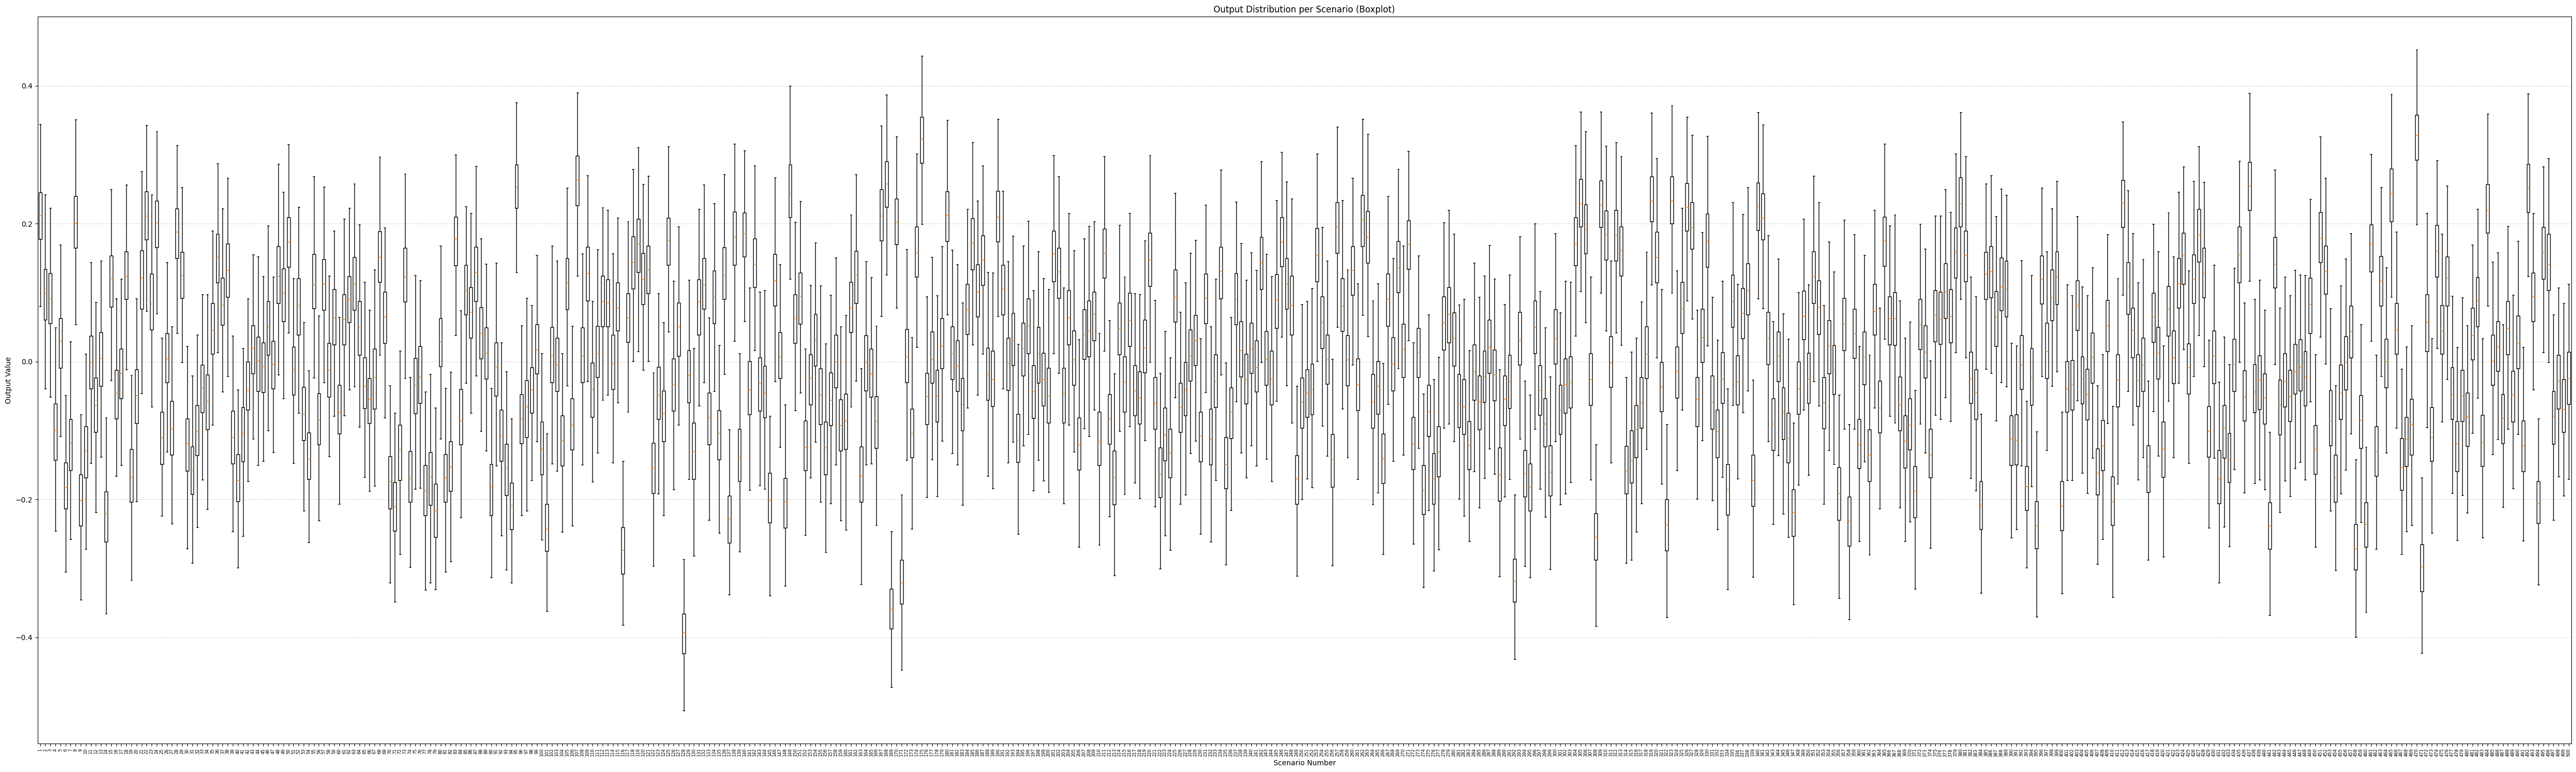

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the full simulation results
df = pd.read_csv("sensitivity_results.csv")

# Setup figure
plt.figure(figsize=(50, 15))  # Wide layout for many scenarios
boxplot_data = [group["Output"].values for name, group in df.groupby("Scenario")]

# Plot
plt.boxplot(boxplot_data, positions=range(1, len(boxplot_data)+1), widths=0.6, showfliers=False)
plt.title("Output Distribution per Scenario (Boxplot)")
plt.xlabel("Scenario Number")
plt.ylabel("Output Value")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xticks(rotation=90, fontsize=6)  # Optional: reduce clutter

# Optional: save the figure
plt.savefig("output_boxplot_all_scenarios.png", dpi=600)

plt.show()


In [18]:
import pandas as pd

# Load the full result file
df = pd.read_csv("sensitivity_results.csv")

# Define linguistic scale function
def classify_linguistic(val):
    if val <= -0.33:
        return "Low"
    elif val >= 0.33:
        return "High"
    else:
        return "Medium"

# Apply linguistic label to each output
df["Label"] = df["Output"].apply(classify_linguistic)

# For each scenario, calculate the percentage of dominant label
def compute_dominant_label_percentage(group):
    counts = group["Label"].value_counts(normalize=True) * 100
    return counts.max()

# Apply to each scenario
linguistic_stability = df.groupby("Scenario").apply(compute_dominant_label_percentage)

# Calculate overall average consistency
average_consistency = linguistic_stability.mean()

# Report
print("📊 Linguistic Stability Analysis (3-scale model):")
print(f"→ Average percentage of outputs in dominant linguistic label per scenario: {average_consistency:.2f}%")

# Optional: save per-scenario values
linguistic_stability.to_csv("linguistic_stability_per_scenario.csv")


📊 Linguistic Stability Analysis (3-scale model):
→ Average percentage of outputs in dominant linguistic label per scenario: 99.26%


<ipython-input-18-efec7f63ed6f>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  linguistic_stability = df.groupby("Scenario").apply(compute_dominant_label_percentage)


📈 Expected Output Range Statistics (80% confidence level):
→ Average Expected Range Width: 0.1396
→ Median Expected Range Width: 0.1404
→ Max Expected Range Width: 0.1541
→ Min Expected Range Width: 0.1061


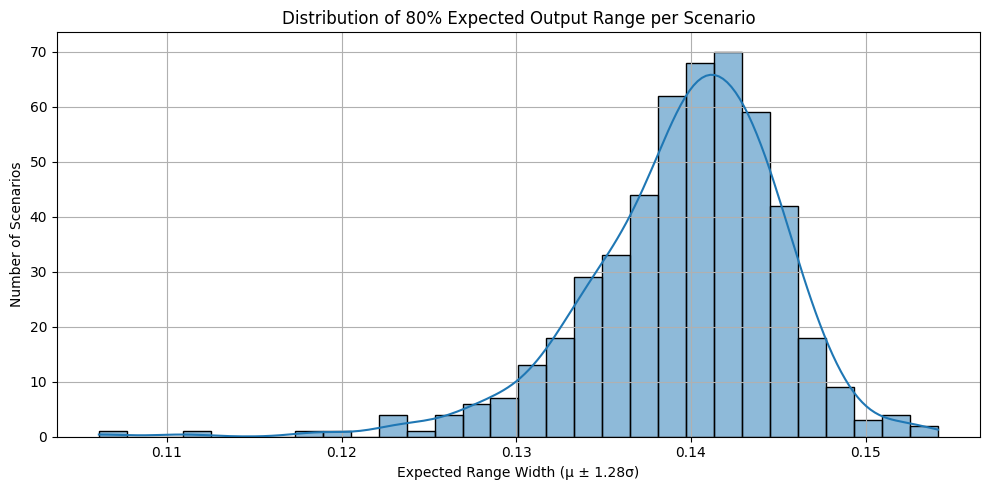

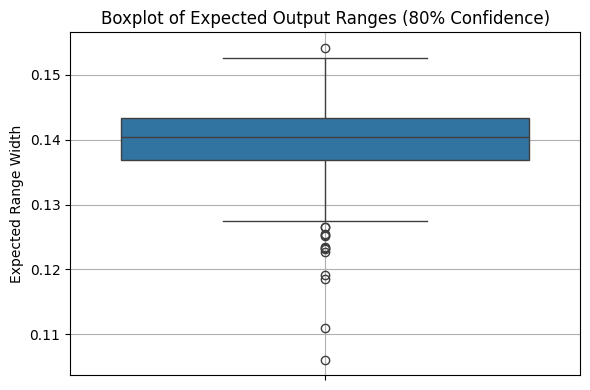

In [32]:
# 📌 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load the sensitivity results file
file_path = "sensitivity_results.csv"  # Replace with your actual path if needed
df = pd.read_csv(file_path)

# 🧮 Group by Scenario and compute output statistics
summary = df.groupby("Scenario")["Output"].agg(
    Mean="mean",
    Std="std"
).reset_index()

# 🔁 Compute Expected Range for 80% confidence interval (µ ± 1.28σ)
z = 1.28
summary["Lower_Bound"] = summary["Mean"] - z * summary["Std"]
summary["Upper_Bound"] = summary["Mean"] + z * summary["Std"]
summary["Expected_Range"] = summary["Upper_Bound"] - summary["Lower_Bound"]

# 📊 Print summary statistics
print("📈 Expected Output Range Statistics (80% confidence level):")
print(f"→ Average Expected Range Width: {summary['Expected_Range'].mean():.4f}")
print(f"→ Median Expected Range Width: {summary['Expected_Range'].median():.4f}")
print(f"→ Max Expected Range Width: {summary['Expected_Range'].max():.4f}")
print(f"→ Min Expected Range Width: {summary['Expected_Range'].min():.4f}")

# 📉 Histogram of expected ranges
plt.figure(figsize=(10, 5))
sns.histplot(summary["Expected_Range"], bins=30, kde=True)
plt.title("Distribution of 80% Expected Output Range per Scenario")
plt.xlabel("Expected Range Width (µ ± 1.28σ)")
plt.ylabel("Number of Scenarios")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📦 Boxplot of expected ranges
plt.figure(figsize=(6, 4))
sns.boxplot(y=summary["Expected_Range"])
plt.title("Boxplot of Expected Output Ranges (80% Confidence)")
plt.ylabel("Expected Range Width")
plt.grid(True)
plt.tight_layout()
plt.show()
